In [1]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import kymatio
from kymatio.torch import TimeFrequencyScattering1D
import librosa
from IPython.display import Audio
import numpy as np
from scipy.spatial.distance import cosine

sr = 44100
shape = 2**16
f0 = 500
f0s = [f0*(2**(n/16)) for n in range(-16*2, 16*2)]

Y = [librosa.tone(f0, sr=sr, length=shape) for f0 in f0s]
y = np.concatenate(Y)
y = librosa.tone(f0, sr=sr, length=shape)
ybis = librosa.tone(f0*(2**(5/16)), sr=sr, length=shape)
Audio(np.concatenate((y, ybis)), rate=sr)
Y = np.stack(Y)

Audio(y, rate=sr)

In [2]:
params = dict(
    J = 14, #scale
    shape = (2**16, ), 
    #Q = 12, #filters per octave, frequency resolution
    T = 2**16, 
    max_pad_factor=1,
    max_pad_factor_fr=1,
    average = True,
)

jtfs_noavg = TimeFrequencyScattering1D(**params, average_fr = False, Q = 8).cuda()
jtfs_avg8 = TimeFrequencyScattering1D(**params, average_fr = True, Q = 8, F = 8).cuda()
jtfs_avg16 = TimeFrequencyScattering1D(**params, average_fr = True, Q = 8, F = 16).cuda()


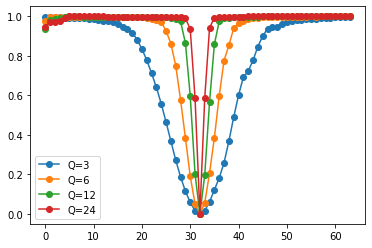

In [81]:
for Q in [3, 6, 12, 24]:
    cqt = np.abs(librosa.cqt(Y, bins_per_octave=Q, fmin=80, n_bins=5*Q)).mean(axis=-1)
    plt.plot([cosine(cqt[32, :].ravel(), cqt[n, :].ravel()) for n in range(64)], '-o', label="Q={}".format(Q))

plt.legend()
#the more frequency resolution, less pitch invariance 

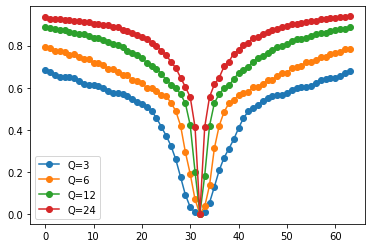

In [7]:
params = dict(
    J = 14, #scale
    shape = (2**16, ), 
    T = 2**16, 
    max_pad_factor=1,
    max_pad_factor_fr=1,
    average = True,
)

for Q in [3, 6, 12, 24]:
    jtfs_avg = TimeFrequencyScattering1D(**params, Q = Q, average_fr = False).cuda()
    jtfs_all = []
    for chan in range(Y.shape[0]):
        jtfs_coef = jtfs_avg(Y[chan,:])
        jtfs_all.append(jtfs_coef.cpu().numpy())
    jtfs_all = np.stack(jtfs_all)
    plt.plot([cosine(jtfs_all[32,:,:].ravel(),jtfs_all[n,:,:].ravel()) for n in range(64)],'-o',
             label="Q={}".format(Q))
plt.legend()

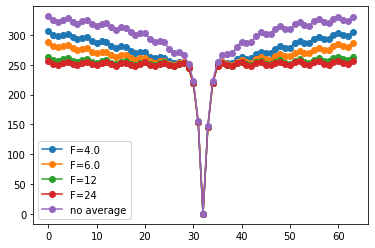

In [10]:
params = dict(
    J = 14, #scale
    shape = (2**16, ), 
    Q = 12, #filters per octave, frequency resolution
    T = 2**16, 
    max_pad_factor=1,
    max_pad_factor_fr=1,
    average = True,
)

Q = 12
jtfs_all = []
for F in [Q/3, Q/2, Q, 2*Q]:
    jtfs_avg = TimeFrequencyScattering1D(**params, average_fr = True, F = F).cuda()
    jtfs_all = []
    for chan in range(Y.shape[0]):
        jtfs_coef = jtfs_avg(Y[chan,:])
        jtfs_all.append(jtfs_coef.cpu().numpy())
    jtfs_all = np.stack(jtfs_all)
    plt.plot([np.linalg.norm(jtfs_all[32,:,:].ravel()-jtfs_all[n,:,:].ravel(),ord=2) for n in range(64)],'-o',
             label="F={}".format(F))

jtfs_noavg = TimeFrequencyScattering1D(**params, average_fr = False).cuda()
jtfs_all = []
for chan in range(Y.shape[0]):
    jtfs_coef = jtfs_noavg(Y[chan,:])
    jtfs_all.append(jtfs_coef.cpu().numpy())
jtfs_all = np.stack(jtfs_all)
plt.plot([np.linalg.norm(jtfs_all[32,:,:].ravel()-jtfs_all[n,:,:].ravel(),ord=2) for n in range(64)],'-o',
         label="no average")

plt.legend()
#same pitch invariance, except at larger neighborhood more averaging means less invariance??

In [8]:
def compute_numcoef(jtfs):
    num = 0
    wav = np.random.random(N,)
    Sw_list = jtfs(wav)
    for i in Sw_list:
        if len(i['j']) == 1:
            num += 1
    return num


In [10]:
import torch

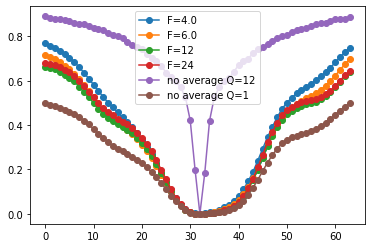

In [12]:
#initialize jtfs instance
N = 2**16
Q = 12
params = dict(J = 14, #scale
        shape = (N, ), 
        T = N, 
        average = True,
        max_pad_factor=1,
        max_pad_factor_fr=1)
jtfs_q1 = TimeFrequencyScattering1D(**params, average_fr = False, Q = 1).cuda()

#compute number of coef

jtfs_q1_list = TimeFrequencyScattering1D(**params, average_fr = False, out_type = "list", Q = 1).cuda()
num_jtfs_q1 = compute_numcoef(jtfs_q1_list)

## when frequential averaging is true, make jtfs this way:
# initialize jtfs (global averaging) and two octaves of frequential averaging


jtfs_all = []
for F in [Q/3, Q/2, Q, 2*Q]:
    jtfs_avg = TimeFrequencyScattering1D(**params, average_fr = True, Q = Q, F = F).cuda() 
    #compute number of coefficients
    jtfs_list = TimeFrequencyScattering1D(**params, average_fr = True, out_type = "list", Q = Q, F = F).cuda()
    num_jtfs = compute_numcoef(jtfs_list)
    
    jtfs_all = []
    for chan in range(Y.shape[0]):
        jtfs_coef = jtfs_avg(Y[chan,:])
        jtfs_coef_q1 = jtfs_q1(Y[chan,:])
        jtfs_comb = torch.concat((jtfs_coef_q1[:,:num_jtfs_q1,:],jtfs_coef[:,num_jtfs:,:]),dim=1)
        jtfs_all.append(jtfs_comb.cpu().numpy())
    jtfs_all = np.stack(jtfs_all)
    plt.plot([cosine(jtfs_all[32,:,:].ravel(),jtfs_all[n,:,:].ravel()) for n in range(64)],'-o',
             label="F={}".format(F))

jtfs_noavg = TimeFrequencyScattering1D(**params, Q=12, average_fr = False).cuda()
jtfs_all = []
for chan in range(Y.shape[0]):
    jtfs_coef = jtfs_noavg(Y[chan,:])
    jtfs_all.append(jtfs_coef.cpu().numpy())
jtfs_all = np.stack(jtfs_all)
plt.plot([cosine(jtfs_all[32,:,:].ravel(),jtfs_all[n,:,:].ravel()) for n in range(64)],'-o',
         label="no average Q=12")

jtfs_noavg2 = TimeFrequencyScattering1D(**params, Q=1, average_fr = False).cuda()
jtfs_all = []
for chan in range(Y.shape[0]):
    jtfs_coef = jtfs_noavg2(Y[chan,:])
    jtfs_all.append(jtfs_coef.cpu().numpy())
jtfs_all = np.stack(jtfs_all)
plt.plot([cosine(jtfs_all[32,:,:].ravel(),jtfs_all[n,:,:].ravel()) for n in range(64)],'-o',
         label="no average Q=1")

plt.legend()


In [53]:
#identify where 2nd order and 1st order coef are 
params = dict(
    J = 14, #scale
    shape = (2**16, ), 
    T = 2**16, 
    max_pad_factor=1,
    max_pad_factor_fr=1,
    average = True,
)
jtfs_q1_list = TimeFrequencyScattering1D(**params, Q = 1, average_fr = True, F = 2,out_type = "list",).cuda()
jtfs_q12_list = TimeFrequencyScattering1D(**params, Q = 12, average_fr = True, F = 24,out_type = "list",).cuda()
jtfs_q1 = TimeFrequencyScattering1D(**params, Q = 1, average_fr = True, F = 2).cuda()
jtfs_q12 = TimeFrequencyScattering1D(**params, Q = 12, average_fr = True, F = 24).cuda()

In [107]:
jtfs_q1_list_avg = jtfs_q1_list = TimeFrequencyScattering1D(**params, Q = 1, average_fr = False,
                                                            out_type = "list",).cuda()

In [108]:
S1 = jtfs_q1(y)
S2 = jtfs_q12(y)
S1_list = jtfs_q1_list(y)
S2_list = jtfs_q12_list(y)
S1_list_avg = jtfs_q1_list_avg(y)

In [109]:
num = 0
order1 = []
for i in S1_list_avg:
    #print(i['j'],i['n'],i['coef'].shape)
    if len(i['j']) == 1:
        num += 1
        if max(i['coef'].cpu().shape) == 1:
            order1.append(i['coef'].cpu().squeeze().numpy())
        else:
            order1.extend(list(i['coef'].cpu().squeeze().numpy()))
print(np.array(order1))
print(num)

[4.65828575e-04 1.50679408e+00 2.97454556e+00 7.11625429e+00
 1.91000053e+01 6.03641800e+01 1.57823408e+02 2.07699603e+01
 1.52947802e-01 1.43038275e-01 1.40641303e-01 1.39932829e-01
 1.39637732e-01 1.39295117e-01 1.38592478e-01 1.43962798e-01]
16


In [93]:
num = 0
order1 = []
for i in S1_list:
    #print(i['j'],i['n'],i['coef'].shape)
    if len(i['j']) == 1:
        num += 1
        if max(i['coef'].cpu().shape) == 1:
            order1.append(i['coef'].cpu().squeeze().numpy())
        else:
            order1.extend(list(i['coef'].cpu().squeeze().numpy()))
print(np.array(order1))
print(num)

 

[4.65828575e-04 1.50679408e+00 2.97454556e+00 7.11625429e+00
 1.91000053e+01 6.03641800e+01 1.57823408e+02 2.07699603e+01
 1.52947802e-01 1.43038275e-01 1.40641303e-01 1.39932829e-01
 1.39637732e-01 1.39295117e-01 1.38592478e-01 1.43962798e-01]
16
149


In [114]:
np.concatenate?

In [116]:
import torch
Scomb = np.concatenate((S1[:,:16,:].numpy(),S2[:,149:,:].numpy()),axis=1)
S1[:,:16,:].shape,S2[:,149:,:].shape,Scomb.shape

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [76]:
print(S1_listarr)


[array(0.00046583), array(1.50679408), array(2.97454556), array(7.11625429), array(19.10000528), array(60.36417996), array(157.82340773), array(20.7699603), array(0.1529478), array(0.14303828), array(0.1406413), array(0.13993283), array(0.13963773), array(0.13929512), array(0.13859248), array(0.1439628), array([34.97314317, 39.97660552, 46.77316356, 42.4367369 , 27.260191  ,
       12.17569203,  3.86086194]), array([16.50855488, 18.17322774, 21.08114965, 21.08925875, 16.86024236,
       10.75146136,  5.75575601]), array([20.11628753, 21.6072633 , 23.73047481, 22.96505832, 18.17279465,
       11.50322896,  5.8971465 ]), array([29.69126839, 29.5898602 , 29.05836516, 26.59249632, 21.65126431,
       15.30023417,  9.46182335]), array([20.59133865, 21.02646328, 21.91636163, 21.87174164, 19.97315926,
       16.41704916, 12.3249796 ]), array([34.94803921, 34.49491419, 32.63130403, 29.53029092, 25.49707082,
       20.9868872 , 16.64231484]), array([17.72665718, 17.60036826, 16.91168116, 15.651

In [34]:
y = librosa.tone(f0, sr=sr, length=shape)
ybis = librosa.tone(f0*(2**(22/12)), sr=sr, length=shape)
Audio(np.concatenate((y, ybis)), rate=sr)

params = dict(
    J = 14, #scale
    shape = (2**16, ), 
    Q = 12, #filters per octave, frequency resolution
    T = 2**16, 
    max_pad_factor=1,
    max_pad_factor_fr=1,
    average = True,
)

jtfs_noavg = TimeFrequencyScattering1D(**params, average_fr = False).cuda()
jtfs_avg8 = TimeFrequencyScattering1D(**params, average_fr = True, F = 1).cuda()
jtfs_avg16 = TimeFrequencyScattering1D(**params, average_fr = True, F = 2).cuda()


torch.Size([1, 1210, 1])


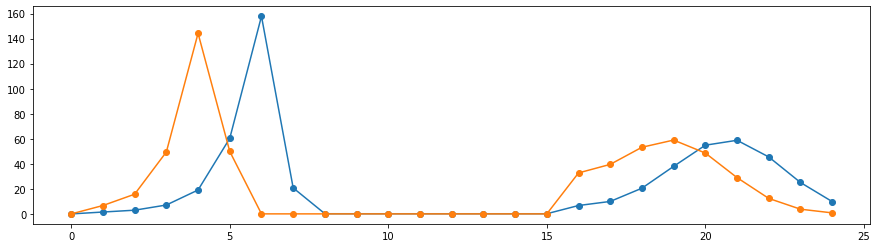

In [35]:
S = jtfs_noavg(y)
Sbis = jtfs_noavg(ybis)
print(S.shape)
plt.figure(figsize=(15, 4))
plt.plot(S.cpu().ravel()[:25], '-o')
plt.plot(Sbis.cpu().ravel()[:25], '-o')

torch.Size([1, 1210, 1])


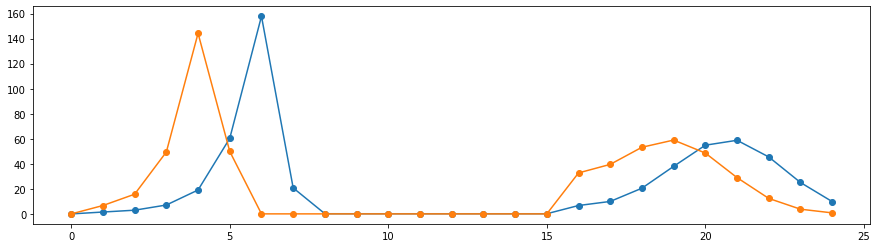

In [36]:
S = jtfs_avg8(y)
Sbis = jtfs_avg8(ybis)
print(S.shape)
plt.figure(figsize=(15, 4))
plt.plot(S.cpu().ravel()[:25], '-o')
plt.plot(Sbis.cpu().ravel()[:25], '-o')

torch.Size([1, 639, 1])


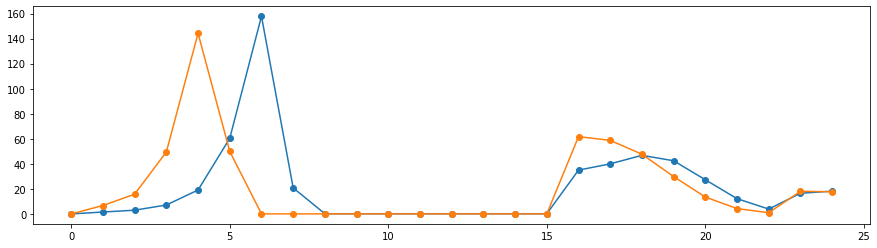

In [37]:
S = jtfs_avg16(y)
Sbis = jtfs_avg16(ybis)
print(S.shape)
plt.figure(figsize=(15, 4))
plt.plot(S.cpu().ravel()[:25], '-o')
plt.plot(Sbis.cpu().ravel()[:25], '-o')

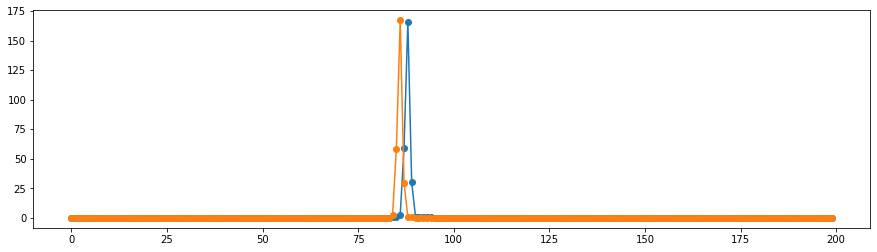

In [40]:
S = jtfs_noavg(y)
Sbis = jtfs_noavg(ybis)

plt.figure(figsize=(15, 4))
plt.plot(S.cpu().ravel()[:200], '-o')
plt.plot(Sbis.cpu().ravel()[:200], '-o')

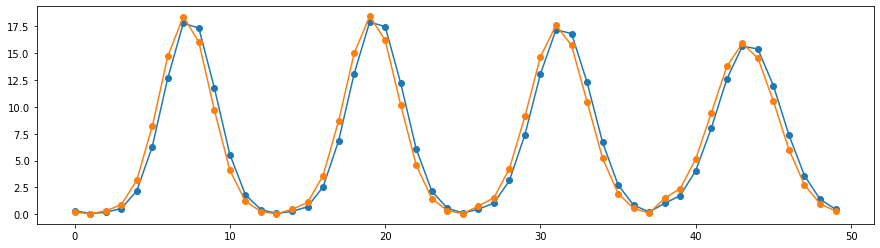

In [52]:
S = jtfs_avg(y)
Sbis = jtfs_avg(ybis)

plt.figure(figsize=(15, 4))
plt.plot(S.cpu().ravel()[250:300], '-o')
plt.plot(Sbis.cpu().ravel()[250:300], '-o')

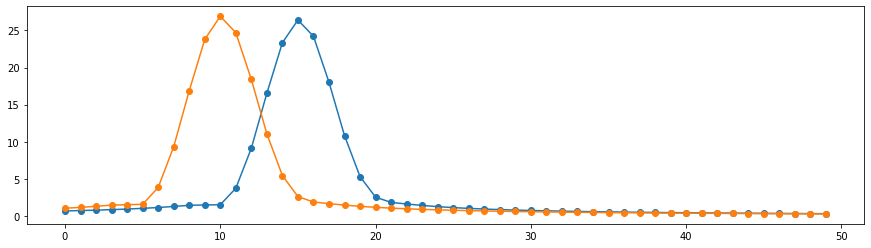

In [53]:
S = jtfs_noavg(y)
Sbis = jtfs_noavg(ybis)

plt.figure(figsize=(15, 4))
plt.plot(S.cpu().ravel()[450:500], '-o')
plt.plot(Sbis.cpu().ravel()[450:500], '-o')